In [1]:
import numpy as np
import io
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

# 데이터 준비

In [2]:
import pathlib

data_dir = "E:\\flower_photos"
data_dir = pathlib.Path(data_dir)

In [3]:
data_dir

WindowsPath('E:/flower_photos')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [5]:
batch_size = 32
img_height = 250
img_width = 250

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [7]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [8]:
for f in list_ds.take(5):
    print(f.numpy())

b'E:\\flower_photos\\roses\\14810868100_87eb739f26_m.jpg'
b'E:\\flower_photos\\roses\\7455236056_b6d71a8dab.jpg'
b'E:\\flower_photos\\roses\\12240165555_98625b1e88_n.jpg'
b'E:\\flower_photos\\dandelion\\155646858_9a8b5e8fc8.jpg'
b'E:\\flower_photos\\daisy\\20329326505_a777c71cc2.jpg'


In [9]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [10]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [11]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


#### 파일 경로를 (img, label) 쌍으로 변환하는 간단한 함수 작성

In [12]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [13]:
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

In [14]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (250, 250, 3)
Label:  3


In [17]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

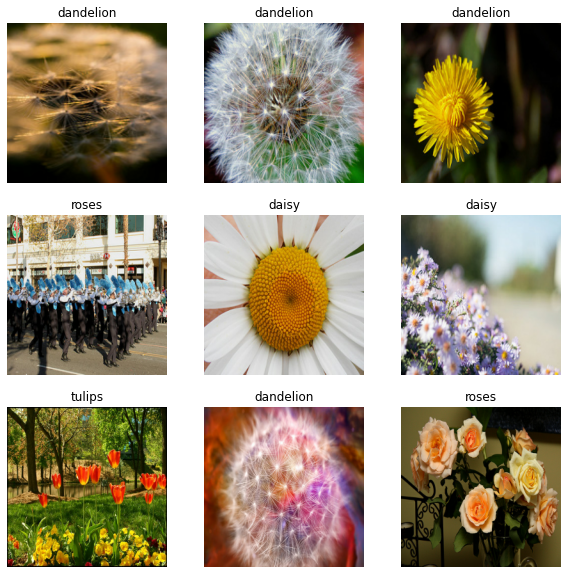

In [18]:
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

# 모델 빌드하기

In [19]:

from tensorflow.keras.applications import ResNet50
from keras.models import Model

input = tf.keras.layers.Input(shape=(img_height, img_width, 3))
model = ResNet50(input_tensor=input, include_top=False, weights=None, pooling='max')

x = model.output
x = tf.keras.layers.Dense(256, activation=None)(x) # No activation on final dense layer
x = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x) # L2 normalize embeddings
model = Model(model.input, x)

# 훈련 및 평가하기

In [20]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [21]:
history = model.fit(
    train_ds,
    epochs=50)

Epoch 1/50
92/92 [==============================] - 51s 419ms/step - loss: 0.9226
Epoch 2/50
92/92 [==============================] - 35s 380ms/step - loss: 0.8957
Epoch 3/50
92/92 [==============================] - 35s 380ms/step - loss: 0.8971
Epoch 4/50
92/92 [==============================] - 35s 380ms/step - loss: 0.8927
Epoch 5/50
92/92 [==============================] - 35s 381ms/step - loss: 0.8832
Epoch 6/50
92/92 [==============================] - 37s 398ms/step - loss: 0.8895
Epoch 7/50
92/92 [==============================] - 36s 393ms/step - loss: 0.8898
Epoch 8/50
92/92 [==============================] - 39s 429ms/step - loss: 0.8896
Epoch 9/50
92/92 [==============================] - 36s 395ms/step - loss: 0.8815
Epoch 10/50
92/92 [==============================] - 35s 386ms/step - loss: 0.8735
Epoch 11/50
92/92 [==============================] - 35s 385ms/step - loss: 0.8763
Epoch 12/50
92/92 [==============================] - 36s 386ms/step - loss: 0.8746
Epoch 13/50
9

In [22]:
# Evaluate the network
results = model.predict(val_ds)

In [23]:
results

array([[-0.07569282,  0.03107871,  0.11907751, ..., -0.01337406,
        -0.04259782,  0.0492739 ],
       [-0.05814995,  0.01524521,  0.11194917, ..., -0.02005758,
        -0.01928235,  0.0334147 ],
       [-0.06382553,  0.00348361,  0.11316027, ..., -0.0112047 ,
        -0.0236924 ,  0.03985364],
       ...,
       [-0.0691466 ,  0.0327029 ,  0.11822364, ..., -0.01852254,
        -0.0336731 ,  0.04212145],
       [-0.01537376, -0.07367849,  0.06166072, ...,  0.00258569,
         0.02884492,  0.00702357],
       [ 0.07195142,  0.1059487 , -0.04086065, ..., -0.07780596,
         0.06529137, -0.07959177]], dtype=float32)

In [24]:
# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(val_ds):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()


In [25]:
history.history

{'loss': [0.9225766658782959,
  0.895723819732666,
  0.8970741629600525,
  0.8926563858985901,
  0.8831754922866821,
  0.8894563317298889,
  0.8897957801818848,
  0.8896307945251465,
  0.8814788460731506,
  0.8734671473503113,
  0.876318633556366,
  0.8745828866958618,
  0.877544105052948,
  0.8806737065315247,
  0.886189877986908,
  0.8776007294654846,
  0.8774457573890686,
  0.879161536693573,
  0.8662524223327637,
  0.8670881986618042,
  0.8760954141616821,
  0.8725335001945496,
  0.8686188459396362,
  0.8725729584693909,
  0.8815716505050659,
  0.8771617412567139,
  0.8754520416259766,
  0.8701897859573364,
  0.8683722615242004,
  0.8666951656341553,
  0.8684677481651306,
  0.8587373495101929,
  0.866101861000061,
  0.863024115562439,
  0.855288565158844,
  0.8559888601303101,
  0.848954975605011,
  0.8500760197639465,
  0.846402645111084,
  0.842827320098877,
  0.8314255475997925,
  0.8338602185249329,
  0.819712221622467,
  0.8231045603752136,
  0.8046997785568237,
  0.8180338144

In [26]:
model.evaluate(val_ds, batch_size=32)

23/23 [==============================] - 4s 123ms/step - loss: 0.8317


0.8316795229911804

In [27]:
# Embedding Projecto
# https://projector.tensorflow.org/